#  Molecule Setup: LiH with Qiskit Nature
This notebook initializes the LiH molecule using Qiskit Nature and PySCF driver. It prepares the molecular Hamiltonian for use with the Variational Quantum Eigensolver (VQE).

In [3]:
'''Install everything from the requiremment.tex and then run this code'''

'Install everything from the requiremment.tex and then run this code'

In [5]:
# pip list | grep qiskit

In [4]:
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper  
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

In [5]:
# Molecule Geometry and Basis
driver = PySCFDriver(
    atom="Li 0.0 0.0 0.0; H 0.0 0.0 1.6",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
electronic_structure = driver.run()

es_problem = ElectronicStructureProblem(electronic_structure.hamiltonian)
es_problem.reference_energy = electronic_structure.reference_energy

In [6]:
# Map the problem to a qubit Hamiltonian
mapper = JordanWignerMapper()
qubit_op = mapper.map(es_problem.second_q_ops()[0]) 
print(qubit_op)

SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIIZZ', 'IIIIIIIIIYYI', 'IIIIIIIIIYYZ', 'IIIIIIIIIXXI', 'IIIIIIIIIXXZ', 'IIIIIIYZZZYI', 'IIIIIIYZZZYZ', 'IIIIIIXZZZXI', 'IIIIIIXZZZXZ', 'IIIIIIIIIZII', 'IIIIIIIIIZIZ', 'IIIIIIYZZYII', 'IIIIIIYZZYIZ', 'IIIIIIXZZXII', 'IIIIIIXZZXIZ', 'IIIIIIIIZIII', 'IIIIIIIIZIIZ', 'IIIIIIIZIIII', 'IIIIIIIZIIIZ', 'IIIIIIZIIIII', 'IIIIIIZIIIIZ', 'IIIIIZIIIIII', 'IIIIIZIIIIIZ', 'IIIIYYIIIIII', 'IIIIYYIIIIIZ', 'IIIIXXIIIIII', 'IIIIXXIIIIIZ', 'IIIYZYIIIIII', 'IIIYZYIIIIIZ', 'IIIXZXIIIIII', 'IIIXZXIIIIIZ', 'YZZZZYIIIIII', 'YZZZZYIIIIIZ', 'XZZZZXIIIIII', 'XZZZZXIIIIIZ', 'IIIIZIIIIIII', 'IIIIZIIIIIIZ', 'IIIYYIIIIIII', 'IIIYYIIIIIIZ', 'IIIXXIIIIIII', 'IIIXXIIIIIIZ', 'YZZZYIIIIIII', 'YZZZYIIIIIIZ', 'XZZZXIIIIIII', 'XZZZXIIIIIIZ', 'IIIZIIIIIIII', 'IIIZIIIIIIIZ', 'YZZYIIIIIIII', 'YZZYIIIIIIIZ', 'XZZXIIIIIIII', 'XZZXIIIIIIIZ', 'IIZIIIIIIIII', 'IIZIIIIIIIIZ', 'IZIIIIIIIIII', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIII', 'ZIIIIIIIIIIZ', 'IIIIIIIIIYZY', 'IIIIIIII

# Ansatz Design for VQE
We build and visualize the ansatz circuit used in the VQE algorithm to approximate the ground state energy of the LiH molecule.

In [7]:
from qiskit.circuit.library import TwoLocal
from qiskit.visualization import plot_histogram, circuit_drawer 
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

/home/ujjwal22/miniconda3/envs/pyscf_env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


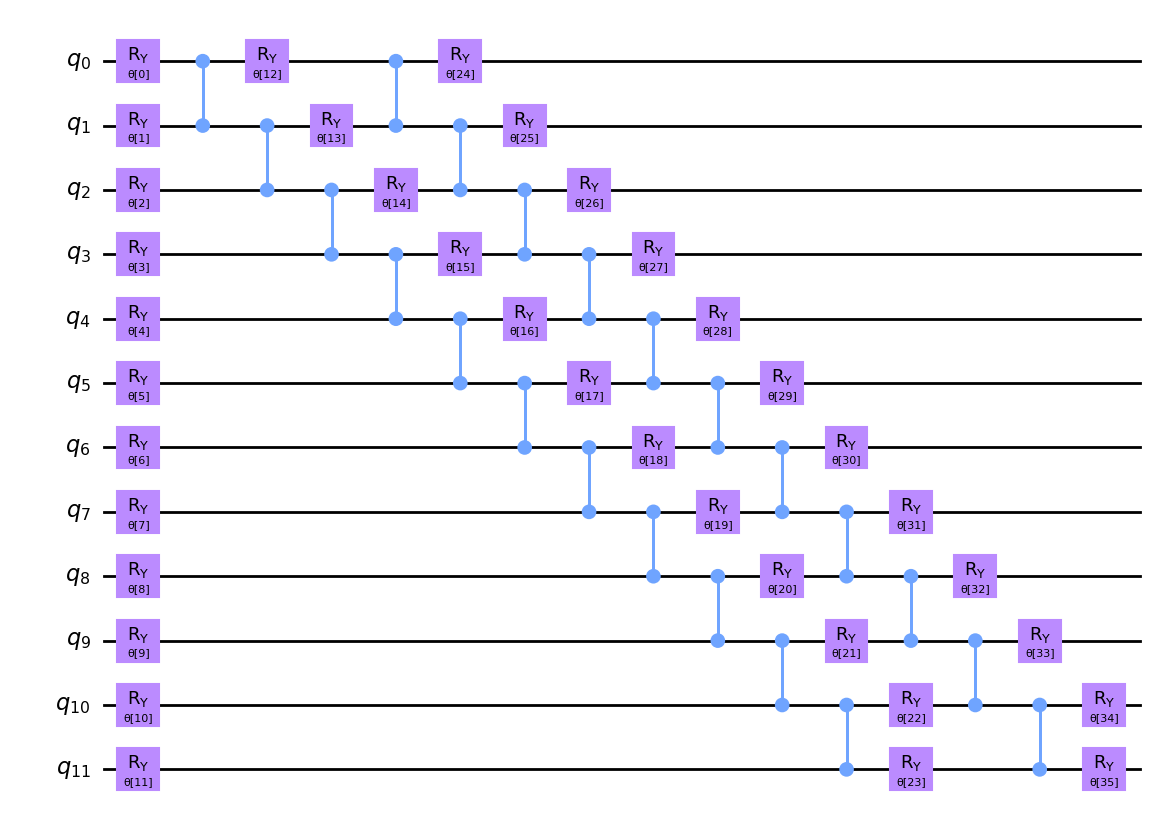

In [8]:
# Ansatz for 4 qubits
ansatz = TwoLocal(num_qubits=12, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=2)
ansatz.decompose().draw('mpl')

In [9]:
# Circuit Plot
fig = ansatz.decompose().draw(output='mpl')
plt.show()

/home/ujjwal22/miniconda3/envs/pyscf_env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


# VQE: Simulator Backend
It integrates the qubit Hamiltonian and ansatz into the VQE workflow using Qiskit's simulator backends. We'll estimate the ground state energy of LiH.

In [10]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.opflow import PauliSumOp
from qiskit_aer.primitives import Estimator
import numpy as np

### Run VQE
Using the Aer simulator for ideal and noisy simulation.

In [11]:
# Initialization
estimator = Estimator()
optimizer = SLSQP(maxiter=50)

energy_history = []

def store_energy(eval_count, parameters, mean, stddev):
    energy_history.append(mean)

vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator, callback=store_energy)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

print("Estimated Ground State Energy:", result.eigenvalue.real)

Estimated Ground State Energy: -5.585020994901663


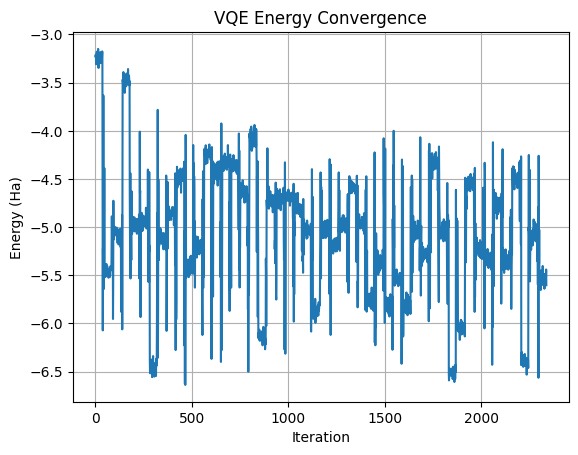

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(energy_history)), energy_history)
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("VQE Energy Convergence")
plt.grid(True)
plt.show()